<a href="https://colab.research.google.com/github/Anoma9/PythonProjects/blob/main/Twitter_Sentiment_Analysis_on_Tesla_Earnings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

THIS PROJECT IS ABOUT GETTING THE SENTIMENT (POSITIVE, NEGATIVE, NEUTRAL) REVIEWS ABOUT TESLA EARNINGS FROM TWITTER USERS

In [ ]:
#IMPORTING LIBRARIES 
import tweepy 
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np 
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
%matplotlib inline
import seaborn as sns
from pandas_profiling import ProfileReport

In [ ]:
#UPLOAD THE DATA
from google.colab import files
uploaded = files.upload()

Saving Logins.csv to Logins.csv


In [ ]:
#READ THE DATA
key = pd.read_csv('Logins.csv')
key

,Keys
0,RuJA4Sn3eDRxkCHd6FGEcZOVC
1,PjhjFPm3pc1NzYljXaMTBqf3eEDx95wUe4LGXskLHVbUTg...
2,1052734736559468544-Udxae2N4lVxIofFJo6hDeJVgL7...
3,S8fRd1nlinPLOxO5Qu7pgJVSMRNn469wHXN4F6xOmE3Oq


In [ ]:
#GET TWITTER API CREDENTIALS
consumer_key = key['Keys'][0]
consumer_secret = key['Keys'][1]
access_token = key['Keys'][2]
access_token_secret = key['Keys'][3]

In [ ]:
#CREATE THE AUTENTICATION OBJECT
authenticate = tweepy.OAuthHandler(consumer_key, consumer_secret)

#SET THE ACCESS TOKEN AND ACCESS TOKEN SECRET
authenticate.set_access_token(access_token, access_token_secret)

#CREATE THE API OBJECT WHILE PASSING IN THE AUTHENTICATE INFORMATION
api = tweepy.API(authenticate, wait_on_rate_limit = True)

In [ ]:
#SPOOL 1500 TWEETS ABOUT TESLA EARNINGS
search_term = 'Tesla Earnings'

#CREATE A CURSOR OBJECT
tweets = tweepy.Cursor(api.search,
                       q = search_term,
                       lang = 'en',
                       since = '2022-03-27',
                       tweet_mode = 'extended'
                       ).items(1500)

#SAVE THE TWEETS IN A VARIABLE
tesla_tweets = [tweet.full_text for tweet in tweets]

#SHOWING ALL OF THE TWEETS
tesla_tweets

In [ ]:
#CREATE A DATAFRAME WITH A COLUMN CALLED TWEETS
df = pd.DataFrame(tesla_tweets, columns=['tweets'])

#SHOW THE FIRST 10 ROWS OF DATA
df.head(10)

,tweets
0,"RT @PiotrRosik: ""Big Tech still carries high v..."
1,"RT @PiotrRosik: ""Big Tech still carries high v..."
2,RT @Tesla: Tesla Q1 Earnings Call and Q&amp;A ...
3,RT @Tesla: Tesla Q1 Earnings Call and Q&amp;A ...
4,"""Big Tech still carries high valuations:\n\n ..."
5,OFFICIAL: Tesla hasn't sold any of its #Bitcoi...
6,RT @alex_avoigt: $tsla stock price and earning...
7,@teslaownersSV In 2019 I read an article about...
8,"Tesla, Inc. (TSLA) surprised the market with Q..."
9,Tesla in trouble with his orders coming in are...


In [ ]:
#CLEANING THE DATA

#CREATE A FUNCTION TO CLEAN THE TWEETS; the r tells python that it is a raw string
def cleanTwt(twt):
  twt = re.sub(r'@[A-Za-z0-9]+','', twt) #removes the @mentions
  twt = re.sub(r'#[A-Za-z0-9]+','', twt) #removes #symbols
  #twt = re.sub(r'RT[\s]+', '', twt) #removes RTs
  twt = re.sub(r'https?:\/\/\S+', '', twt) #removes the hyperlink in a test
  twt = re.sub(r'\/n\/', '', twt) #removes the '\n' character
  twt = re.sub(r'^[\s]+|[\s]+$', '', twt) #removes leading and training whitespaces
  twt = re.sub('RT','', twt)
  return twt

#CLEANING THE TEST
df['cleaned_tweets'] = df['tweets'].apply(cleanTwt)

#SHOW CLEAN TEXT
df.head()

In [ ]:
#REMOVE EVERY DUPLICATE VALUES
#CREATE A NEW DATAFRAME
df = pd.DataFrame(df['cleaned_tweets'], columns=['cleaned_tweets'])

#REMOVE ANY DUPLICATE ROWS
df.drop_duplicates(inplace=True)
idx = list(range(0, len(df)))
df = df.set_index(pd.Index(idx))

#SHOW THE DATA
df.shape[0]

214

In [ ]:
#CREATE A FUNCTION TO GET THE SUBJECTIVITY;
#which is a measure of how subjective or objective a tweet is.
#It has a value of 0 - 1 with 0 being very objective and 1 being very subjective
def getSubjectivity(twt):
  return TextBlob(twt).sentiment.subjectivity

#CREATE A FUNCTION TO GET THE POLARITY; tells how positive or negative the text is
def getPolarity(twt):
  return TextBlob(twt).sentiment.polarity

#CREATE TWO NEW COLUMNS; subjectivity and polarity 
df['subjectivity'] = df['cleaned_tweets'].apply(getSubjectivity)
df['polarity'] = df['cleaned_tweets'].apply(getPolarity)

#SHOW THE FIRST TEN ROWS OF THE DATAFRAME
df.head(10)

,cleaned_tweets,subjectivity,polarity
0,": ""Big Tech still carries high valuations:\n\...",0.255000,0.053333
1,: Tesla Q1 Earnings Call and Q&amp;A →,0.000000,0.000000
2,"""Big Tech still carries high valuations:\n\n ...",0.255000,0.053333
3,OFFICIAL: Tesla hasn't sold any of its - Tesl...,0.000000,0.000000
4,_avoigt: $tsla stock price and earnings expec...,0.000000,0.000000
5,In 2019 I read an article about someone invest...,0.100000,0.333333
6,"Tesla, Inc. (TSLA) surprised the market with Q...",0.650000,0.050000
7,Tesla in trouble with his orders coming in are...,0.150000,-0.125000
8,: .⁦⁩ stock rallies 10% as results/outlook to...,0.500000,0.500000
9,.⁦⁩ stock rallies 10% as results/outlook top S...,0.166667,0.166667


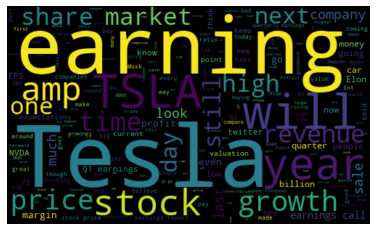

In [ ]:
#SHOWING HOW THE SENTIMENTS ARE DISTRIBUTED BY PLOTTING A WORDCLOUD
all_words = ' '.join( [twts for twts in df['cleaned_tweets']] )
wordcloud = WordCloud(width=500, height=300, random_state=21, max_font_size=119).generate(all_words)

plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [ ]:
#CREATE A FUNCTION TO CLASSIFY OR LABEL THE SENTIMENTS AS 
#NEGATIVE, NEUTRAL AND POSITIVE 

def getSentiment(value):
  if value <0:
    return 'Negative'
  elif value ==0:
    return 'Neutral'
  else:
    return 'Positive'

df['sentiment'] = df['polarity'].apply(getSentiment)

#SHOW THE DATAFRAME
df.head()

,cleaned_tweets,subjectivity,polarity,sentiment
0,": ""Big Tech still carries high valuations:\n\...",0.255,0.053333,Positive
1,: Tesla Q1 Earnings Call and Q&amp;A →,0.000,0.000000,Neutral
2,"""Big Tech still carries high valuations:\n\n ...",0.255,0.053333,Positive
3,OFFICIAL: Tesla hasn't sold any of its - Tesl...,0.000,0.000000,Neutral
4,_avoigt: $tsla stock price and earnings expec...,0.000,0.000000,Neutral


In [ ]:
#PRINT ALL OF THE POSITIVE TWEETS
a=1
sortedDF = df.sort_values(by=['polarity'])
for i in range(0, sortedDF.shape[0]):
  if(sortedDF['sentiment'][i]=='Positive'):
    print(str(a) + ')'+sortedDF['cleaned_tweets'][i], '\n')
    print()
    a=a+1

1) : "Big Tech still carries high valuations:

    : 24.4x exp. future 12-m earnings
     : 26.6x
    : 1… 


2)"Big Tech still carries high valuations:

    : 24.4x exp. future 12-m earnings
     : 26.6x
    : 19.4x
    : 78.4x
    : 58.3x
    : 16.1x
    : 34.1x

S&amp;P 500 trades for 17.1x FE, S&amp;P Tech for 20.5x 


3)In 2019 I read an article about someone investing 20 million in Tesla prior to the third Qtr earnings call.  I had just inherited some money looked into Tesla and bought shares. Best investment I have made. 


4)Tesla, Inc. (TSLA) surprised the market with Q4 result.  J.P. Morgan Chase changed the rating to Sell, as Tesla, Inc. (TSLA) current year earnings has been revised 20% downward. 


5) : .⁦⁩ stock rallies 10% as results/outlook top Street view.

* Revenue $620.4 million, up 50% yoy

* Annual Re… 


6).⁦⁩ stock rallies 10% as results/outlook top Street view.

* Revenue $620.4 million, up 50% yoy

* Annual Recurring Rev (ARR) $899.8 million up 29% yoy

* GAAP 

In [ ]:
#PRINT THE NEGATIVE TWEETS
a=1
sortedDF = df.sort_values(by=['polarity'], ascending='False')
for i in range(0, sortedDF.shape[0]):
  if(sortedDF['sentiment'][i]=='Negative'):
    print(str(a) + ')'+sortedDF['cleaned_tweets'][i], '\n')
    print()
    a=a+1

1)Tesla in trouble with his orders coming in are weakening earnings !Tesla has big problems in China . 


2)_an_ie_clair  Are you mentally handicapped?  Net earnings at Tesla is up 657% year over year.  Earning per share up on quarter and beating guidance.

Did you just hope I wouldn't check?  Why lie?  This is sad 


3)Tesla must be having a bad quarter. Can’t wait for the bad earnings report 


4)Gary black calling for tesla stock buybacks, instead of spending on r&amp;d or expansion.
Price to earnings over 100. 
Amazon 50
Goog 20
Appl 24
Fb 15

Fanboi gonna fanboi/bagholder gonna baghold 


5)None here, at least quick search for semi, partner and test returns nothing remotely suggesting that.
There were claims in 2018 or so but those can be ignored.

Until we start seeing them on road (even a few) I take it all with major grain of salt. 


6)Everything is negative to these idiots. ZEV credits are one time, don't count them. Temporary shutdown in China, Tesla is doomed. Temporary sup

<function matplotlib.pyplot.show>

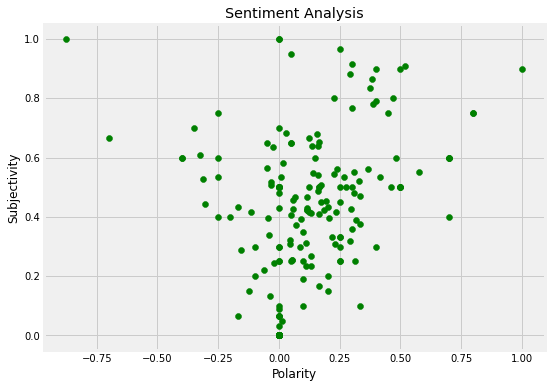

In [ ]:
#SHOW THE SCATTER PLOT OF THE SUBJECTIVITY AND POLARITY
plt.figure(figsize=(8,6))
for i in range(0,df.shape[0]):
  plt.scatter(df['polarity'][i], df['subjectivity'][i], color='green')

plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show

In [ ]:
# SHOW THE PERCENTAGE OF POSITIVE TWEETS
ptweets = df[df.sentiment=='Positive']
ptweets = ptweets['cleaned_tweets']

round(ptweets.shape[0] / df.shape[0] *100,1)

52.3

In [ ]:
# SHOW THE PERCENTAGE OF NEGATIVE TWEETS
ptweets = df[df.sentiment=='Negative']
ptweets = ptweets['cleaned_tweets']

round(ptweets.shape[0] / df.shape[0] *100,1)

14.0

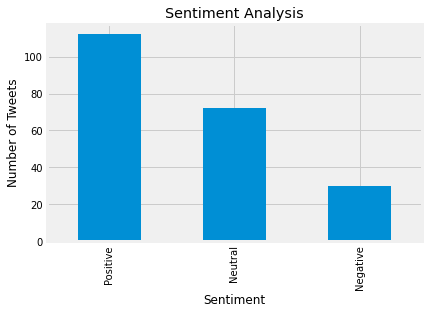

In [ ]:
#SHOW THE VALUE COUNTS OF 
df['sentiment'].value_counts()

#SHOW THE VIZUALIZATION OF THE COUNTS
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
df['sentiment'].value_counts().plot(kind='bar')